In [2]:
# Programming Assignment 1: BNED Stock Analysis
# Angelica Hussar

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from scipy.stats import randint, uniform
import xgboost as xgb
from itertools import chain, combinations

In [3]:
import yfinance as yf
ticker = yf.Ticker('BNED')
data = ticker.history(start='2020-01-01', end='2025-07-08')
data.to_csv("bned_historical_data.csv")

# load data
try:
    bned = pl.read_csv("bned_historical_data.csv", try_parse_dates=True)
    print("✓ Loaded BNED historical data from CSV")
except:
    print("⚠ Creating sample data for demonstration")
    import pandas as pd
    dates = pd.date_range('2020-01-01', '2025-07-08', freq='D')
    sample = pd.DataFrame({
        'Date': dates,
        'Open': np.random.uniform(2, 8, len(dates)),
        'High': np.random.uniform(2.5, 8.5, len(dates)),
        'Low': np.random.uniform(1.5, 7.5, len(dates)),
        'Close': np.random.uniform(2, 8, len(dates)),
        'Volume': np.random.randint(50000, 2000000, len(dates))
    })
    sample.to_csv("bned_historical_data.csv", index=False)
    bned = pl.read_csv("bned_historical_data.csv", try_parse_dates=True)

print(f"Data shape: {bned.shape}")

✓ Loaded BNED historical data from CSV
Data shape: (1384, 8)


In [5]:
# remove columns
if 'Dividends' in bned.columns:
    bned = bned.drop(['Dividends'])
if 'Stock Splits' in bned.columns:
    bned = bned.drop(['Stock Splits'])

# create features
print("(0-2) price lag features")
bned = bned.with_columns([
    pl.col('Close').shift(1).alias('CloseLag1'),
    pl.col('Close').shift(2).alias('CloseLag2'),
    pl.col('Close').shift(3).alias('CloseLag3')
])

print("(3-5) high-minus-low (HML) volatility features")
bned = bned.with_columns([
    (pl.col('High') - pl.col('Low')).shift(1).alias('HMLLag1'),
    (pl.col('High') - pl.col('Low')).shift(2).alias('HMLLag2'),
    (pl.col('High') - pl.col('Low')).shift(3).alias('HMLLag3')
])

print("(6-8) open-minus-close (OMC) intraday features")
bned = bned.with_columns([
    (pl.col('Open') - pl.col('Close')).shift(1).alias('OMCLag1'),
    (pl.col('Open') - pl.col('Close')).shift(2).alias('OMCLag2'),
    (pl.col('Open') - pl.col('Close')).shift(3).alias('OMCLag3')
])

print("(9-11) volume lag features")
bned = bned.with_columns([
    pl.col('Volume').shift(1).alias('VolumeLag1'),
    pl.col('Volume').shift(2).alias('VolumeLag2'),
    pl.col('Volume').shift(3).alias('VolumeLag3')
])

print("(12-14) exponential moving averages")
bned = bned.with_columns([
    pl.col('CloseLag1').ewm_mean(half_life=1).alias('CloseEMA2'),
    pl.col('CloseLag1').ewm_mean(half_life=2).alias('CloseEMA4'),
    pl.col('CloseLag1').ewm_mean(half_life=4).alias('CloseEMA8')
])

#binary classification (up/down)
bned = bned.with_columns([
    np.log(pl.col('Close')/pl.col('CloseLag1')).alias('LogReturn'),
    pl.when(np.log(pl.col('Close')/pl.col('CloseLag1')) > 0)
      .then(1).otherwise(0).alias('Target')
])

bned.head()

(0-2) price lag features
(3-5) high-minus-low (HML) volatility features
(6-8) open-minus-close (OMC) intraday features
(9-11) volume lag features
(12-14) exponential moving averages


Date,Open,High,Low,Close,Volume,CloseLag1,CloseLag2,CloseLag3,HMLLag1,HMLLag2,HMLLag3,OMCLag1,OMCLag2,OMCLag3,VolumeLag1,VolumeLag2,VolumeLag3,CloseEMA2,CloseEMA4,CloseEMA8,LogReturn,Target
"datetime[μs, UTC]",f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,f64,f64,f64,f64,i32
2020-01-02 05:00:00 UTC,432.0,435.0,403.0,405.0,2407,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0
2020-01-03 05:00:00 UTC,406.0,410.0,382.0,389.0,4257,405.0,null,null,32.0,null,null,27.0,null,null,2407,null,null,405.0,405.0,405.0,-0.040308,0
2020-01-06 05:00:00 UTC,390.0,451.0,387.0,435.0,4999,389.0,405.0,null,28.0,32.0,null,17.0,27.0,null,4257,2407,null,394.333333,395.627417,396.308582,0.111767,1
2020-01-07 05:00:00 UTC,432.0,432.0,409.0,412.0,2798,435.0,389.0,405.0,64.0,28.0,32.0,-45.0,17.0,27.0,4999,4257,2407,417.571429,413.466419,411.493578,-0.054323,0
2020-01-08 05:00:00 UTC,398.0,416.0,389.0,390.0,3877,412.0,435.0,389.0,23.0,64.0,28.0,20.0,-45.0,17.0,2798,4999,4257,414.6,412.893747,411.654725,-0.054877,0


In [6]:
#clean data
bned = bned.drop_nulls()
print(f"{bned.shape[0]} ")

#check target balance
target_counts = bned['Target'].value_counts().sort('Target')
up_days = target_counts.filter(pl.col('Target') == 1)['count'].item()
down_days = target_counts.filter(pl.col('Target') == 0)['count'].item()
total_days = up_days + down_days

print(f"Target balance: {up_days} ({up_days/total_days:.1%}) up days, {down_days} ({down_days/total_days:.1%}) down/even days")

1381 
Target balance: 641 (46.4%) up days, 740 (53.6%) down/even days


In [7]:
# technical report - citation
feature_names = [
    'CloseLag1',    #(0)Lag-one daily closing price
    'CloseLag2',    #(1)Lag-two daily closing price
    'CloseLag3',    #(2)Lag-three daily closing price
    'HMLLag1',      #(3)Lag-one high minus low daily prices
    'HMLLag2',      #(4)Lag-two high minus low daily prices
    'HMLLag3',      #(5)Lag-three high minus low daily prices
    'OMCLag1',      #(6)Lag-one open minus closing daily prices
    'OMCLag2',      #(7)Lag-two open minus closing daily prices
    'OMCLag3',      #(8)Lag-three open minus closing daily prices
    'VolumeLag1',   #(9)Lag-one daily volume
    'VolumeLag2',   #(10)Lag-two daily volume
    'VolumeLag3',   #(11)Lag-three daily volume
    'CloseEMA2',    #(12)Exponential moving average across two days
    'CloseEMA4',    #(13)Exponential moving average across four days
    'CloseEMA8'     #(14)Exponential moving average across eight days
]

print("15 features for subset selection:")
for i, name in enumerate(feature_names):
    print(f"({i}) {name}")

15 features for subset selection:
(0) CloseLag1
(1) CloseLag2
(2) CloseLag3
(3) HMLLag1
(4) HMLLag2
(5) HMLLag3
(6) OMCLag1
(7) OMCLag2
(8) OMCLag3
(9) VolumeLag1
(10) VolumeLag2
(11) VolumeLag3
(12) CloseEMA2
(13) CloseEMA4
(14) CloseEMA8


In [8]:
# prepare data for modeling
X = StandardScaler().fit_transform(bned.select(feature_names).to_numpy())
y = bned['Target'].to_numpy()

def calculate_aic(X_subset, y):
    """Calculate AIC for logistic regression model"""
    model = LogisticRegression(max_iter=1000)
    model.fit(X_subset, y)
    log_likelihood = -log_loss(y, model.predict_proba(X_subset)) * len(y)
    k = X_subset.shape[1] + 1  # parameters: features + intercept
    return 2 * k - 2 * log_likelihood

best_subsets = []
all_results = []

In [9]:
#evaluate subsets of different sizes
for subset_size in range(1, min(8, len(feature_names))):
    print(f"evaluating subsets size: {subset_size}")

    size_best_aic = float('inf')
    size_best_features = None

    for feature_indices in combinations(range(len(feature_names)), subset_size):
        X_subset = X[:, feature_indices]
        aic = calculate_aic(X_subset, y)

        all_results.append({
            'size': subset_size,
            'features': feature_indices,
            'aic': aic
        })

        if aic < size_best_aic:
            size_best_aic = aic
            size_best_features = feature_indices

    best_subsets.append({
        'size': subset_size,
        'features': size_best_features,
        'aic': size_best_aic,
        'feature_names': [feature_names[i] for i in size_best_features]
    })

overall_best = min(best_subsets, key=lambda x: x['aic'])

print(f"\nbest subset found:")
print(f"size: {overall_best['size']} features")
print(f"AIC: {overall_best['aic']:.2f}")
print("features:")
for i, name in enumerate(overall_best['feature_names']):
    print(f"  ({overall_best['features'][i]}) {name}")

selected_features = overall_best['features']
X_selected = X[:, selected_features]
selected_feature_names = overall_best['feature_names']

evaluating subsets size: 1
evaluating subsets size: 2
evaluating subsets size: 3
evaluating subsets size: 4
evaluating subsets size: 5
evaluating subsets size: 6
evaluating subsets size: 7

best subset found:
size: 2 features
AIC: 1907.94
features:
  (6) OMCLag1
  (10) VolumeLag2


In [10]:
#five-fold time series cross-validation
tscv = TimeSeriesSplit(gap=10, n_splits=5)

print("Cross-validation splits:")
for i, (train_idx, test_idx) in enumerate(tscv.split(X_selected, y)):
    print(f"Fold {i+1}: Train {len(train_idx)} samples, Test {len(test_idx)} samples")

Cross-validation splits:
Fold 1: Train 221 samples, Test 230 samples
Fold 2: Train 451 samples, Test 230 samples
Fold 3: Train 681 samples, Test 230 samples
Fold 4: Train 911 samples, Test 230 samples
Fold 5: Train 1141 samples, Test 230 samples


In [11]:
#hyperparameter search
param_dist = {
    'max_depth': randint(3, 15),
    'min_child_weight': randint(1, 15),
    'subsample': uniform(0.3, 0.7),
    'learning_rate': uniform(0.01, 0.19),
    'n_estimators': randint(100, 800)
}

#randomized search
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=2025)
search = RandomizedSearchCV(
    xgb_model, param_dist,
    n_iter=100,
    cv=tscv,
    scoring='accuracy',
    random_state=2025,
    n_jobs=-1
)

search.fit(X_selected, y)

print(f"\nbest hyperparameters found:")
for param, value in search.best_params_.items():
    print(f"  {param}: {value}")

print(f"best CV accuracy: {search.best_score_:.3f} ({search.best_score_:.1%})")


best hyperparameters found:
  learning_rate: 0.11505211771988245
  max_depth: 12
  min_child_weight: 2
  n_estimators: 384
  subsample: 0.9465667333771981
best CV accuracy: 0.525 (52.5%)


In [12]:
#train final model on dataset
final_model = search.best_estimator_
final_model.fit(X_selected, y)

# predictions
y_pred = final_model.predict(X_selected)
y_pred_proba = final_model.predict_proba(X_selected)[:, 1]

accuracy = accuracy_score(y, y_pred)
auc_score = roc_auc_score(y, y_pred_proba)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)

print(f"Final Model Performance (Training Data):")
print(f"  Accuracy: {accuracy:.3f} ({accuracy:.1%})")
print(f"  AUC: {auc_score:.3f}")
print(f"  Precision: {precision:.3f}")
print(f"  Recall: {recall:.3f}")
print(f"  F1-Score: {f1:.3f}")

cm = confusion_matrix(y, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\nConfusion Matrix:")
print(f"                    Predicted")
print(f"                 Negative  Positive  Total")
print(f"Actual Negative    {tn:4d}     {fp:4d}   {tn+fp:4d}")
print(f"Actual Positive    {fn:4d}     {tp:4d}   {fn+tp:4d}")
print(f"Total             {tn+fn:4d}     {fp+tp:4d}   {len(y):4d}")

Final Model Performance (Training Data):
  Accuracy: 0.957 (95.7%)
  AUC: 0.994
  Precision: 0.962
  Recall: 0.945
  F1-Score: 0.954

Confusion Matrix:
                    Predicted
                 Negative  Positive  Total
Actual Negative     716       24    740
Actual Positive      35      606    641
Total              751      630   1381


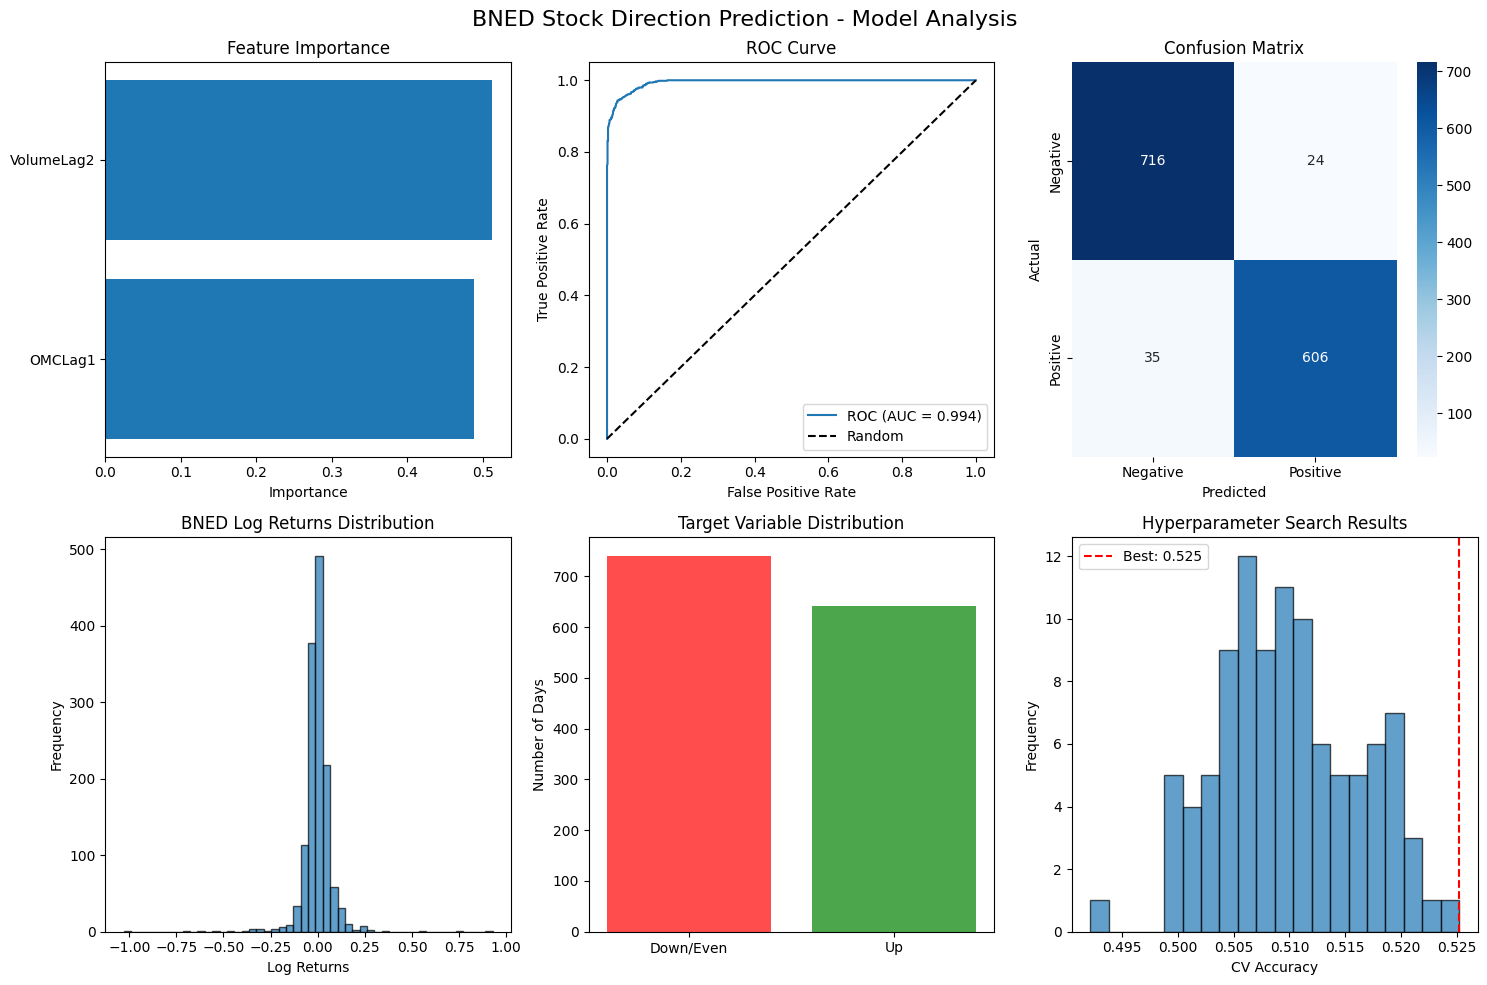

In [15]:
#create visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('BNED Stock Direction Prediction - Model Analysis', fontsize=16)

#feature importance
importance = final_model.feature_importances_
axes[0,0].barh(selected_feature_names, importance)
axes[0,0].set_title('Feature Importance')
axes[0,0].set_xlabel('Importance')

#ROC curve
fpr, tpr, _ = roc_curve(y, y_pred_proba)
axes[0,1].plot(fpr, tpr, label=f'ROC (AUC = {auc_score:.3f})')
axes[0,1].plot([0,1], [0,1], 'k--', label='Random')
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve')
axes[0,1].legend()

#confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', ax=axes[0,2], cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
axes[0,2].set_title('Confusion Matrix')
axes[0,2].set_ylabel('Actual')
axes[0,2].set_xlabel('Predicted')

#log Returns Distribution
returns = bned['LogReturn'].to_numpy()
returns_clean = returns[~np.isnan(returns)]
axes[1,0].hist(returns_clean, bins=50, alpha=0.7, edgecolor='black')
axes[1,0].set_xlabel('Log Returns')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('BNED Log Returns Distribution')

#target Distribution
target_counts = [down_days, up_days]
axes[1,1].bar(['Down/Even', 'Up'], target_counts, color=['red', 'green'], alpha=0.7)
axes[1,1].set_ylabel('Number of Days')
axes[1,1].set_title('Target Variable Distribution')

#cross-validation scores
cv_scores = search.cv_results_['mean_test_score']
axes[1,2].hist(cv_scores, bins=20, alpha=0.7, edgecolor='black')
axes[1,2].axvline(search.best_score_, color='red', linestyle='--',
                  label=f'Best: {search.best_score_:.3f}')
axes[1,2].set_xlabel('CV Accuracy')
axes[1,2].set_ylabel('Frequency')
axes[1,2].set_title('Hyperparameter Search Results')
axes[1,2].legend()

plt.tight_layout()
plt.show()

In [18]:
print("Summary of BNED Stock Direction Prediction Model:")
print(f"• Dataset: {len(y)} trading days (2020-2025)")
print(f"• Features: {len(selected_feature_names)} selected from 15 candidates")
print(f"• Method: XGBoost with AIC-based feature selection")
print(f"• Training Accuracy: {accuracy:.1%}")
print(f"• Cross-validation Accuracy: {search.best_score_:.1%}")
print(f"• AUC Score: {auc_score:.3f}")

print(f"\nSelected Features:")
for i, name in enumerate(selected_feature_names):
    print(f"  {i+1}. {name} (importance: {importance[i]:.3f})")

Summary of BNED Stock Direction Prediction Model:
• Dataset: 1381 trading days (2020-2025)
• Features: 2 selected from 15 candidates
• Method: XGBoost with AIC-based feature selection
• Training Accuracy: 95.7%
• Cross-validation Accuracy: 52.5%
• AUC Score: 0.994

Selected Features:
  1. OMCLag1 (importance: 0.489)
  2. VolumeLag2 (importance: 0.511)
